In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
df = pd.read_csv("data/processed_data.csv")
X = df[["CK", "QT_x", "QT_y"]]  # Features (Predictors)
y = df["HP_grade"]  # Target variable

In [17]:
# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [18]:
# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Predict on the test set
y_pred = lr.predict(X_test)

In [19]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [20]:
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error: 0.0010
Root Mean Squared Error: 0.0323
R-squared (R²): 0.9994


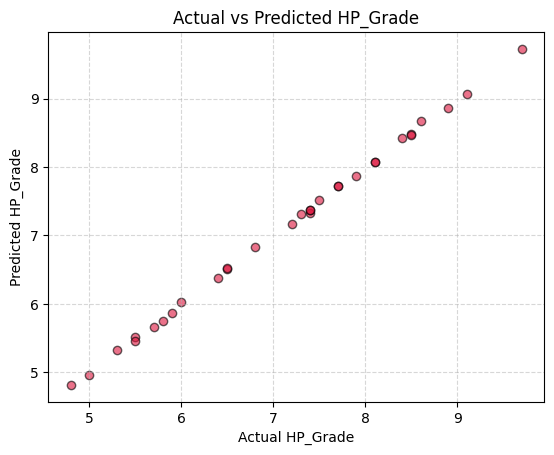

In [21]:
# Visualize actual vs predicted
plt.scatter(y_test, y_pred, color="crimson", alpha=0.6, edgecolors="black")
plt.xlabel("Actual HP_Grade")
plt.ylabel("Predicted HP_Grade")
plt.title("Actual vs Predicted HP_Grade")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [22]:
X = df[["CK", "QT_x", "QT_y", "KT_TB", "KT1"]]  # Features (Predictors)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [23]:
# Train the Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)
# Predict on the test set
y_pred = lr.predict(X_test)

In [24]:
# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

In [25]:
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Squared Error: 0.0010
Root Mean Squared Error: 0.0321
R-squared (R²): 0.9994


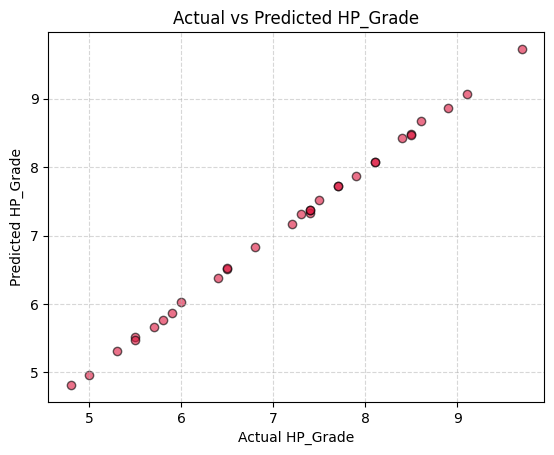

In [26]:
# Visualize actual vs predicted
plt.scatter(y_test, y_pred, color="crimson", alpha=0.6, edgecolors="black")
plt.xlabel("Actual HP_Grade")
plt.ylabel("Predicted HP_Grade")
plt.title("Actual vs Predicted HP_Grade")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()